<a href="https://colab.research.google.com/github/takada-at/sep_crawl/blob/master/sep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

クローラーの準備

In [2]:
# @title クローラーの準備
% cd /content
! if [ ! -d sep_crawl ]; then git clone https://github.com/takada-at/sep_crawl.git; fi
% cd sep_crawl
! git pull
! pip install -r requirements-colab.txt

/content
Cloning into 'sep_crawl'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 100 (delta 48), reused 85 (delta 33), pack-reused 0
Receiving objects: 100% (100/100), 25.43 KiB | 6.36 MiB/s, done.
Resolving deltas: 100% (48/48), done.
/content/sep_crawl
Already up to date.
     |████████████████████████████████| 235kB 2.8MB/s 
     |████████████████████████████████| 102kB 27.6MB/s 
     |████████████████████████████████| 3.1MB 42.3MB/s 
     |████████████████████████████████| 61kB 22.2MB/s 
     |████████████████████████████████| 174kB 41.9MB/s 
     |████████████████████████████████| 61kB 22.7MB/s 
     |████████████████████████████████| 2.3MB 24.5MB/s 
     |████████████████████████████████| 102kB 21.9MB/s 
  Created wheel for PyDispatcher: filename=PyDispatcher-2.0.5-cp36-none-any.whl size=11517 sha256=51318535d33bd6a773ad7738ea5a785393422446ad3693fefc499824df647c1d
  Stored i

In [89]:
# @title SEP記事のダウンロード
# @markdown 80分程度かかります。
% cd /content/sep_crawl/sep/
! if [ -d ../data/sep ]; then rm -r ../data/sep; fi
! time scrapy crawl entry --loglevel=INFO
! cat ../data/sep/text/*.txt > ../data/sep/sep-entries.txt

/content/sep_crawl/sep
2019-08-16 07:45:49 [scrapy.utils.log] INFO: Scrapy 1.7.3 started (bot: sep)
2019-08-16 07:45:49 [scrapy.utils.log] INFO: Versions: lxml 4.2.6.0, libxml2 2.9.8, cssselect 1.1.0, parsel 1.5.2, w3lib 1.21.0, Twisted 19.7.0, Python 3.6.8 (default, Jan 14 2019, 11:02:34) - [GCC 8.0.1 20180414 (experimental) [trunk revision 259383]], pyOpenSSL 19.0.0 (OpenSSL 1.1.1c  28 May 2019), cryptography 2.7, Platform Linux-4.14.79+-x86_64-with-Ubuntu-18.04-bionic
2019-08-16 07:45:49 [scrapy.crawler] INFO: Overridden settings: {'AUTOTHROTTLE_ENABLED': True, 'BOT_NAME': 'sep', 'CONCURRENT_REQUESTS': 32, 'COOKIES_ENABLED': False, 'DOWNLOAD_DELAY': 1, 'LOG_LEVEL': 'INFO', 'NEWSPIDER_MODULE': 'sep.spiders', 'ROBOTSTXT_OBEY': True, 'SPIDER_MODULES': ['sep.spiders']}
2019-08-16 07:45:49 [scrapy.extensions.telnet] INFO: Telnet Password: a70f8f17487d2345
2019-08-16 07:45:49 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet

In [93]:
# @title ダウンロードしたファイルの確認
# 行数
! wc -l /content/sep_crawl/data/sep/sep-entries.txt 
! head /content/sep_crawl/data/sep/sep-entries.txt 
# ダウンロードした記事の確認
! ls /content/sep_crawl/data/sep/text | head
! ls /content/sep_crawl/data/sep/text | tail
! ls /content/sep_crawl/data/sep/text | wc -l

588639 /content/sep_crawl/data/sep/sep-entries.txt
in the philosophical literature the term abduction is used in two related but different senses
in both senses the term refers to some form of explanatory reasoning
however in the historically first sense it refers to the place of explanatory reasoning in generating hypotheses while in the sense in which it is used most frequently in the modern literature it refers to the place of explanatory reasoning in justifying hypotheses
in the latter sense abduction is also often called inference to the best explanation 
 this entry is exclusively concerned with abduction in the modern sense although there is a supplement on abduction in the historical sense which had its origin in the work of charles sanders peirce see the 
 supplement peirce on abduction
see also the entry on   scientific discovery   in particular the section on discovery as abduction
most philosophers agree that abduction in the sense of inference to the best explanation is a 

In [92]:
# @title Google Driveにバックアップ
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

% cd /content
! if [ -d sep-entries ]; then rm -r sep-entries; fi
! mkdir sep-entries
! cp /content/sep_crawl/data/sep/sep-entries.txt sep-entries/
! zip /content/sep-entries.zip sep-entries
! cp /content/sep-entries.zip "/content/drive/My Drive/"

Mounted at /content/drive
/content
updating: sep-entries/ (stored 0%)


In [91]:
# @title Google Driveからインポート

from google.colab import drive
drive.mount('/content/drive',  force_remount=True)
! cp "/content/drive/My Drive/sep-entries.zip" /content/sep-entries.zip 
% cd /content
! unzip sep-entries.zip
! mv sep-entries/sep-entries.txt /content/sep_crawl/data/sep/sep-entries.txt

Mounted at /content/drive
/content
Archive:  sep-entries.zip
replace sep-entries/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace sep-entries/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: sep-entries/.DS_Store   
  inflating: __MACOSX/sep-entries/._.DS_Store  
  inflating: sep-entries/sep-entries.txt  
  inflating: __MACOSX/sep-entries/._sep-entries.txt  
  inflating: __MACOSX/._sep-entries  


In [94]:
# @title word2vecモデルの作成
from datetime import datetime
from gensim.models.word2vec import LineSentence
from gensim.models import Word2Vec

sentences = LineSentence('/content/sep_crawl/data/sep/sep-entries.txt')
s = datetime.now()
w2v = Word2Vec(sentences, size=200)
e = datetime.now()
print('create word2vec model: {}'.format(e - s))

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


create word2vec model: 0:02:20.046959


In [107]:
print(len(w2v.wv.vocab))
w2v.wv.most_similar(positive=["kant"], topn=9)


42869


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('hegel', 0.7343728542327881),
 ('hume', 0.692112922668457),
 ('fichte', 0.690702497959137),
 ('herder', 0.6699775457382202),
 ('leibniz', 0.6553886532783508),
 ('spinoza', 0.6551713943481445),
 ('bergson', 0.6433348059654236),
 ('schelling', 0.6413836479187012),
 ('nietzsche', 0.6403198838233948)]

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


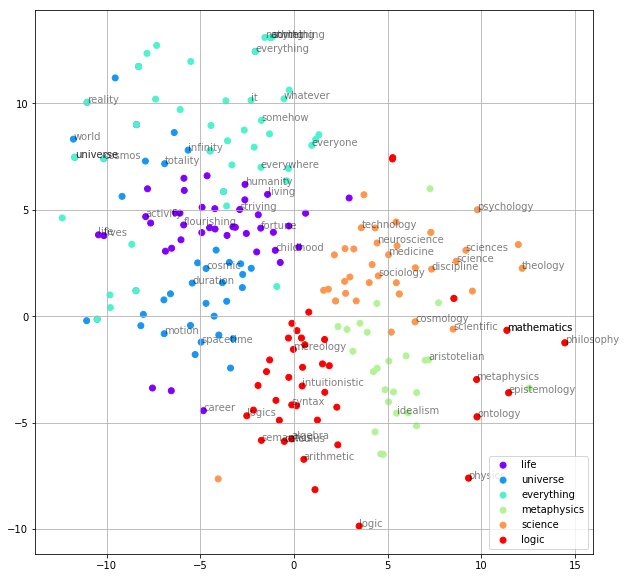

In [110]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm

topics = ['life', 'universe', 'everything', 'metaphysics', 'science', 'logic']
# topics = ['Kant', 'Hegel', 'Hume']
dim = 200
neighbor_name_list = []
neighbor_vectors = []
for i, t in enumerate(topics):
  neighbors = w2v.wv.most_similar(positive=[t], topn=40)
  names = [t] + [n[0] for n in neighbors]
  neighbor_name_list.append(names)
  vectors = np.vstack([w2v.wv[w] for w in names])
  neighbor_vectors.append(vectors)

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=40.0)
matrix = np.vstack(neighbor_vectors)
v2d = tsne.fit_transform(matrix)
x = v2d[:, 0]
y = v2d[:, 1]
plt.figure(figsize=(10, 10))
colors = cm.rainbow(np.linspace(0, 1, len(topics)))
for i, label in enumerate(topics):
  color = colors[i]
  names = neighbor_name_list[i]
  cnt = len(names)
  l = cnt * i
  r = l + cnt
  xs = x[l:r]
  ys = y[l:r]
  plt.scatter(xs, ys, c=[color]*cnt, label=label)
  for j, n in enumerate(names[:10]):
    plt.annotate(n, alpha=0.5, xy=(xs[j], ys[j]))
plt.legend(loc=4)
plt.grid(True)  
plt.show()
  